# Predicting Readmission
In this module we will look at a binary prediction of readmission.  For this we seek to predict a readmission from the current admision.  This means that our unit of analysis changes from the patient to the 

In [1]:
# Load our helpers
source("../using.R")
source("../percent.R")
source("../sift.R")
# Load our packages
using( tidyverse, magrittr, RMySQL, DBI, dbplyr, stringr, lubridate
     , forcats, ggplot2, modelr, caret, broom)

# connect to the database
mimic.db <- dbConnect( RMySQL::MySQL(), host="mysql", port=3306
                     , user="jovyan", password="jovyan", dbname="mimic2"
                     )
# Expose all the tables.
assign_mimic <- . %>% assign(., tbl(mimic.db, .), envir=globalenv())
mimic <- dbListTables(mimic.db) %>%
        structure(names=., lapply(., assign_mimic))

Loading required package: tidyverse
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: magrittr
Loading required package: RMySQL
Loading required package: DBI
Loading required package: dbplyr
Loading required package: stringr
Loading required package: lubridate
Loading required package: forcats
Loading required package: modelr
Loading required package: caret
Loading required package: lattice
Loading required package: broom


## Define Analysis Data 

### Admisions

The first step is to define the response variable, readmission.  We are not concerned if a patient is ever readmitted, but if they are readmitted within 90 days.  For the purpose of simplicity in illustration we are going to ignore if the readmission is for the same condition or not. 

In [2]:
admissions.tbl <- 
    # start with patients
    d_patients %>% 

    # join to admissions
    left_join(admissions) %>% 

    # ensure correct order
    arrange(subject_id, admit_dt) %>% collect %>%
    
    # clean up variables from SQL
    mutate( admit_dt  = ymd_hms(admit_dt)
          , disch_dt  = ymd_hms(disch_dt)
          , dob       = ymd_hms(dob)
          , dod       = ymd_hms(dod)
          , admit_los = interval(admit_dt, disch_dt)/ddays(1)
          , age_at_discharge = interval(dob, disch_dt)/dyears(1)
          ) %>%
    
    # compute time since last admission
    group_by(subject_id) %>% 
    mutate( time.since.last.disch = interval(lag(disch_dt, 1, default=unique(dob)), admit_dt)/ddays(1)
          , readmission.wi.30days = time.since.last.disch <= 30
          , readmission.wi.90days = time.since.last.disch <= 90
          , readmission.wi.1year  = interval(lag(disch_dt, 1, default=unique(dob)), admit_dt)/dyears(1) <= 1
          ) %>%
    mutate( has.readmit.wi.90days = lead(readmission.wi.90days, 1, FALSE)) %>% ungroup

Joining, by = "subject_id"


#### What is going on?
* first find the last discharge date.

In [3]:
# For illustration we restrict to the patients with multiple admissions 
# and only look at the variables we are currently working with.
subject.admission.counts <- count(admissions.tbl, subject_id)
tmp0 <- admissions.tbl %>%
    inner_join(filter(subject.admission.counts, n >= 4)) %>%
    select(subject_id, dob, admit_dt, disch_dt)
    
tmp1 <- tmp0 %>%
    group_by(subject_id) %>% 
    mutate( last_disch =                
               lag( disch_dt, 1        # lag means shift by one  
                  , default=unique(dob)# with the first element being
                                       # the date of birth.
                  )
          )

# Now lets look at the top of the table.
tmp1 %>% head()

Joining, by = "subject_id"


subject_id,dob,admit_dt,disch_dt,last_disch
353,3036-09-03,3095-07-27,3095-08-15,3036-09-03
353,3036-09-03,3098-05-08,3098-05-24,3095-08-15
353,3036-09-03,3098-08-03,3098-08-14,3098-05-24
353,3036-09-03,3098-11-11,3098-11-30,3098-08-14
634,2753-12-27,2816-07-22,2816-07-31,2753-12-27
634,2753-12-27,2816-08-08,2816-08-11,2816-07-31


* Next compute the time between last discharge and the current admission.

In [4]:
tmp2 <- mutate(tmp1, 
    time.since.last.disch =           # Take the time period
       interval(last_disch, admit_dt) # from previous discharge to current admission
       / ddays(1)                      # measured in number of days.
      )
head(tmp2)

subject_id,dob,admit_dt,disch_dt,last_disch,time.since.last.disch
353,3036-09-03,3095-07-27,3095-08-15,3036-09-03,21511
353,3036-09-03,3098-05-08,3098-05-24,3095-08-15,997
353,3036-09-03,3098-08-03,3098-08-14,3098-05-24,71
353,3036-09-03,3098-11-11,3098-11-30,3098-08-14,89
634,2753-12-27,2816-07-22,2816-07-31,2753-12-27,22853
634,2753-12-27,2816-08-08,2816-08-11,2816-07-31,8


* Now compute our variables of interest, which you can see up above.

#### moving on

How many readmissions within 90 days do we have?

In [5]:
admissions.tbl %>% ungroup %>% count(has.readmit.wi.90days)

has.readmit.wi.90days,n
FALSE,4520
TRUE,602


### ICU

Here we summarize the icu visits to one row per hospital admission.

In [6]:
admit.icu <- 
    
    # We start with the icustay_detail which includes more information
    # than the individual tables and is already combined together.
    icustay_detail %>% collect %>%

    # select only the ICU and index variables
    # (because there are more variables).
    select(subject_id, hadm_id, icustay_id, starts_with('icustay')) %>% 
    
    # and remove any possible duplicate rows
    # (just to be safe, might be unneccessary)
    distinct %>%
    
    # Convert our variables to dates.
    # This is actually unneccessary because we don't use these
    # but it is good form to fix it now in case we 
    # do use it later.
    mutate( icu_intime  = ymd_hms(icustay_intime)
          , icu_outitme = ymd_hms(icustay_outtime)
          ) %>%
    
    # We want output as one row per hadm_id
    group_by(hadm_id) %>%
    
    # and we want to derive variables:
    summarise( has_icu = TRUE         # Does the visit have an incu stay
                                      # when we merge we will get missing
                                      # values that we will replace with 
                                      # FALSE.
             , n_icu   = n()          # Number of ICU visits and 
             , icu_minutes =          # and the total time (in minutes) in
                  sum(icustay_los)    # the ICU, both of which we will
                                      # replace with 0 after merging.
             ) %>%
    ungroup  # and we don't want the grouping to be carried forward.


### ICD-9 Tables

ICD-9 Tells us a whole lot about the patients and the visits.  There would be **a lot** of time that would be spent here getting these variables right. We will do about the most naive thing that we can, because we are lazy. ;-)

In [7]:
count(icd9) %>% rename(Observations = n) %>% collect()
glimpse(icd9)

Observations
53486


Observations: 25
Variables: 5
$ subject_id  <int> 56, 56, 56, 56, 56, 56, 56, 56, 37, 37, 37, 37, 37, 37,...
$ hadm_id     <int> 28766, 28766, 28766, 28766, 28766, 28766, 28766, 28766,...
$ sequence    <int> 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2...
$ code        <chr> "198.3", "162.8", "531.40", "276.1", "428.0", "780.39",...
$ description <chr> "SECONDARY MALIGNANT NEOPLASM OF BRAIN AND SPINAL C", "...


Let's get some understanding of the `icd9` table.

In [8]:
icd9 %>% summarise( rows         = n()
                  , subjects     = count(distinct(subject_id))
                  , codes        = count(distinct(code))
                  , descriptions = count(distinct(description))
                  ) %>%
collect() %>%
gather(Type, 'Count of distinct')

Type,Count of distinct
rows,53486
subjects,3951
codes,2719
descriptions,3605


![](https://media.giphy.com/media/GVWBkBHggD77G/giphy.gif)

**Problem**  
The number of codes and the description should be the same. 

Here I give you the [`get_duplicated()`](../../../edit/predictive_analytics/get_duplicated.R) function to help out.

In [9]:
source("../get_duplicated.R")
get_duplicated(icd9, code, description) %>% head

# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
    code                                       description
   <chr>                                             <chr>
1  007.4                                 CRYPTOSPORIDIOSIS
2  007.4      "OTH PROTOZOAL INT DISEAS                \r"
3 008.45 INTESTINAL INFECTION DUE TO CLOSTRIDIUM DIFFICILE
4 008.45      "INTESTIN INF CLOSTRIOIUM                \r"
5 008.69            ENTERITIS DUE TO OTHER VIRAL ENTERITIS
6 008.69      "ENTERITIS D/T OTH VIRUS                 \r"

To make sense of ICD-9 codes we will use the [`icd`](https://cran.r-project.org/package=icd) R package.

In [10]:
using(icd)

Loading required package: icd
Welcome to the "icd" package for finding comorbidities and interpretation of ICD-9 and ICD-10 codes. Suggestions and contributions are welcome at https://github.com/jackwasey/icd .

See the vignettes and help for examples.

Please cite this package if you find it useful in your published work.
citation(package = "icd")



First are all of our ICD-9 codes valid?

In [11]:
collect(count(icd9))
icd9 %>% select(code) %>% collect %$% 
    as.icd9cm(code) %>% icd_is_valid %>% sum

n
53486


[1] 53486

Use the code but get explanations from the `icd` package.

In [12]:
# take the icd9 table
icd.expl.tbl <- icd9 %>%
    # We only need unique codes for now, but we need it local.
    select(code) %>% distinct%>% collect %$%
    # explain the icd9 codes present in our data. 
    icd_explain_table(as.icd9cm(code)) %>%
    # store as a tbl, not a raw data.frame
    tbl_df %>%
    # and present icd9 codes with decimal point.
    mutate(code = icd_short_to_decimal(code))

In [13]:
head(icd.expl.tbl)

code,short_desc,long_desc,three_digit,major,sub_chapter,chapter,is_major,valid_icd9,valid_icd10
198.3,Sec mal neo brain/spine,Secondary malignant neoplasm of brain and spinal cord,198,Secondary malignant neoplasm of other specified sites,Malignant Neoplasm Of Other And Unspecified Sites,Neoplasms,FALSE,TRUE,FALSE
162.8,Mal neo bronch/lung NEC,Malignant neoplasm of other parts of bronchus or lung,162,"Malignant neoplasm of trachea, bronchus, and lung",Malignant Neoplasm Of Respiratory And Intrathoracic Organs,Neoplasms,FALSE,TRUE,FALSE
531.40,Chr stomach ulc w hem,"Chronic or unspecified gastric ulcer with hemorrhage, without mention of obstruction",531,Gastric ulcer,"Diseases Of Esophagus, Stomach, And Duodenum",Diseases Of The Digestive System,FALSE,TRUE,FALSE
276.1,Hyposmolality,Hyposmolality and/or hyponatremia,276,"Disorders of fluid, electrolyte, and acid-base balance",Other Metabolic And Immunity Disorders,"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",FALSE,TRUE,TRUE
428.0,CHF NOS,"Congestive heart failure, unspecified",428,Heart failure,Other Forms Of Heart Disease,Diseases Of The Circulatory System,FALSE,TRUE,TRUE
780.39,Convulsions NEC,Other convulsions,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE


In [14]:
icd9 %>% collect %>%
    mutate(code = as.icd9cm(code)) %>%
    left_join(icd.expl.tbl) %>% 
    group_by(Chapter = chapter) %>%
    summarise( Codes      = length(unique(code))
             , Subjects   = length(unique(subject_id))
             , Admissions = length(unique(hadm_id))
             )

Joining, by = "code"
Warning message:
“Column `code` has different attributes on LHS and RHS of join”

Chapter,Codes,Subjects,Admissions
Infectious And Parasitic Diseases,124,1408,1644
Neoplasms,217,1069,1227
"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",132,2726,3404
Diseases Of The Blood And Blood-Forming Organs,55,1585,1881
Mental Disorders,95,901,1037
Diseases Of The Nervous System And Sense Organs,177,865,1021
Diseases Of The Circulatory System,275,3466,4413
Diseases Of The Respiratory System,108,2519,3055
Diseases Of The Digestive System,218,1589,1923
Diseases Of The Genitourinary System,96,2011,2431


Now we do the naive thing.

We group icd-9 codes by *chapter* and agregate to the hospital admission.

But first, let's make the chapter easier to read.  Some of those chapter titles are *long*.

In [15]:
abrv_chapter <- . %>% 
fct_recode( 'Infectious and Parasitic'      = 'Infectious And Parasitic Diseases'
          , 'Neoplasms'                     = 'Neoplasms'
          , 'Metabolic and Immunity'        = 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
          , 'Blood and Blood-Forming Organs'= 'Diseases Of The Blood And Blood-Forming Organs'
          , 'Mental Disorders'              = 'Mental Disorders'
          , 'Nervous and Sense Organs'      = 'Diseases Of The Nervous System And Sense Organs'
          , 'Circulatory System'            = 'Diseases Of The Circulatory System'
          , 'Respiratory System'            = 'Diseases Of The Respiratory System'
          , 'Digestive System'              = 'Diseases Of The Digestive System'
          , 'Genitourinary System'          = 'Diseases Of The Genitourinary System'
          , 'Pregnancy and Childbirth'      = 'Complications Of Pregnancy, Childbirth, And The Puerperium'
          , 'Skin and Subcutaneous Tissue'  = 'Diseases Of The Skin And Subcutaneous Tissue'
          , 'Musculoskeletal and Connective'= 'Diseases Of The Musculoskeletal System And Connective Tissue'
          , 'Congenital Anomalies'          = 'Congenital Anomalies'
          , 'Cond. Orig. Perinatal Period'  = 'Certain Conditions Originating In The Perinatal Period'
          , 'Symptoms and Signs'            = 'Symptoms, Signs, And Ill-Defined Conditions'
          , 'Injury and Poisoning'          = 'Injury And Poisoning'
          , 'Supp - Factors and Contact'    = 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
          , 'Supp - External Causes'        = 'Supplementary Classification Of External Causes Of Injury And Poisoning'
          )

In [16]:
admit.icd9 <- 
    # Start with icd9 table, bring it local.
    icd9 %>% collect %>%
    
    # Join it to our icd9.expl.tbl to get chapter
    left_join(icd.expl.tbl) %>%
    
    # count the number of icd9 codes in each 
    # chapter, subject_id, and hadm_id
    count(subject_id, hadm_id, chapter) %>% 
    
    # Abbreviate the chapter
    mutate(chapter = abrv_chapter(chapter)) %>%
    
    # now spread out the data so that it is one row per admission.
    # it is important to specify fill=0 to fill in the missing
    # values as zero.
    spread(chapter, n, fill=0)

head(admit.icd9)

Joining, by = "code"
Warning message:
“Column `code` has different attributes on LHS and RHS of join”

subject_id,hadm_id,Infectious and Parasitic,Neoplasms,Metabolic and Immunity,Blood and Blood-Forming Organs,Mental Disorders,Nervous and Sense Organs,Circulatory System,Respiratory System,⋯,Genitourinary System,Pregnancy and Childbirth,Skin and Subcutaneous Tissue,Musculoskeletal and Connective,Congenital Anomalies,Cond. Orig. Perinatal Period,Symptoms and Signs,Injury and Poisoning,Supp - Factors and Contact,Supp - External Causes
3,2075,1,0,1,0,0,0,4,0,⋯,1,0,1,0,0,0,1,0,0,0
12,12532,0,1,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,2,0,1
21,20666,1,0,3,1,0,0,8,1,⋯,1,0,0,0,0,0,1,0,1,0
21,20882,2,1,3,1,0,0,5,1,⋯,0,0,2,0,0,0,1,2,1,1
26,15067,0,0,1,0,0,0,5,0,⋯,2,0,0,0,0,0,0,1,0,0
31,15325,0,1,0,0,0,2,2,2,⋯,0,0,0,0,0,0,0,0,0,1


### Combine all the table together
We eventually need a single flat table that is one row per admission to use in the prediction models.

In [17]:
admit.data <- 
    admissions.tbl %>% 
    left_join(admit.icu) %>%
    left_join(admit.icd9) %>%
    # We need to restrict to our defined population.
    filter(interval(dob, admit_dt)/dyears(1) > 12) %>%
    # Some final adjustments
    select( -dod, -hospital_expire_flg   #< not available at time of discharge.
          , -dob, -admit_dt, -disch_dt   #< because it's not relevant between patients.  
          ) %>% 
    # Some special cleanup from joins
    # From ICU
        # coalesce replaces the missing values
        mutate( has_icu     = coalesce(has_icu, FALSE)
              ,   n_icu     = coalesce(n_icu, 0L)
              , icu_minutes = coalesce(icu_minutes, 0)
              ) %>%
    # From ICD-9 Code Chapters
        mutate_at( vars(`Infectious and Parasitic`:`Supp - External Causes`)
                 , coalesce, 0
                 ) %>%
    # And no guesses for Sex so we will drop those
        filter(!is.na(sex))
      
# check to see if we handled all the missing values.
glimpse(admit.data)
summarise_all(admit.data, . %>% is.na %>% sum) %>% 
    gather(Variable, Missing) %>% 
    filter(Missing > 0) %>%
    count()


Joining, by = "hadm_id"
Joining, by = c("subject_id", "hadm_id")


Observations: 5,032
Variables: 32
$ subject_id                     <int> 3, 12, 21, 21, 26, 31, 37, 56, 61, 6...
$ sex                            <chr> "M", "M", "M", "M", "M", "M", "M", "...
$ hadm_id                        <int> 2075, 12532, 20666, 20882, 15067, 15...
$ admit_los                      <dbl> 11, 13, 13, 9, 7, 8, 5, 6, 33, 30, 0...
$ age_at_discharge               <dbl> 76.60548, 72.45479, 87.53151, 87.906...
$ time.since.last.disch          <dbl> 27950, 26433, 31936, 128, 26299, 263...
$ readmission.wi.30days          <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ readmission.wi.90days          <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ readmission.wi.1year           <lgl> FALSE, FALSE, FALSE, TRUE, FALSE, FA...
$ has.readmit.wi.90days          <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ has_icu                        <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, ...
$ n_icu                          <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, ...
$ icu_minutes     

n
0


# Fitting Models

## Train/Test/Validation Split

The first thing for any machine learning predictive model is to split the available data into a testing and training sets.  Also for many models it is good practice to use a validation set for the final performance metrics if you plan on itterating using the test data.

We have 5,061 patients that we will split 60, 20, 20 to train, test, validataion.

**Note:**  
When doing randomization it is a good idea to set the RNG seed to make the sampling reproducible.  Alternatively one can save the stored sets, however this has the disadvantage of causing complications if the sampled data changes in any way, for example, adding variables. 

In [18]:
set.seed(20170728)
train <- admit.data %>% sample_frac(0.60)
test  <- admit.data %>% anti_join(train) %>% sample_frac(0.50)
validation <- admit.data %>% anti_join(train) %>% anti_join(test)

count(train     ) %>% rename("Train set size" = n)
count(test      ) %>% rename("Test set size" = n)
count(validation) %>% rename("Vaildation set size" = n)

Joining, by = c("subject_id", "sex", "hadm_id", "admit_los", "age_at_discharge", "time.since.last.disch", "readmission.wi.30days", "readmission.wi.90days", "readmission.wi.1year", "has.readmit.wi.90days", "has_icu", "n_icu", "icu_minutes", "Infectious and Parasitic", "Neoplasms", "Metabolic and Immunity", "Blood and Blood-Forming Organs", "Mental Disorders", "Nervous and Sense Organs", "Circulatory System", "Respiratory System", "Digestive System", "Genitourinary System", "Pregnancy and Childbirth", "Skin and Subcutaneous Tissue", "Musculoskeletal and Connective", "Congenital Anomalies", "Cond. Orig. Perinatal Period", "Symptoms and Signs", "Injury and Poisoning", "Supp - Factors and Contact", "Supp - External Causes")
Joining, by = c("subject_id", "sex", "hadm_id", "admit_los", "age_at_discharge", "time.since.last.disch", "readmission.wi.30days", "readmission.wi.90days", "readmission.wi.1year", "has.readmit.wi.90days", "has_icu", "n_icu", "icu_minutes", "Infectious and Parasitic", "Ne

Train set size
3019


Test set size
1006


Vaildation set size
1007


Now a check.

In [19]:
# An example from purrr

# take a list of datasets.
list( train = train
    , test = test
    , validation = validation
    ) %>% 
    # Map - for each element in the list, ie. dataset
    #       count  has.readmit.wi.90days, with Set as
    map_df( count, has.readmit.wi.90days, .id="Set") %>%
    #       variable that identified the element from 
    #       the list 

    # make the table wide
    spread( has.readmit.wi.90days, n ) %>% 
    # and compute the percent of TRUE.
    mutate(Pct.TRUE = `TRUE`/(`TRUE` + `FALSE`))

Set,FALSE,TRUE,Pct.TRUE
test,880,126,0.1252485
train,2673,346,0.1146075
validation,878,129,0.1281033


Does the percent look even*ish* across sets?

## Logistic Regression

We start with the most common for binary prediction and work to refinements. Although Logisitic regression does give nicely interpretable coeficients we are not going to focus on that looking only at the predictive performance 

In [20]:
readmission.logistic <- 
    # Logistic regression is in the class of Generalized Linear Models (glm)
    glm( has.readmit.wi.90days ~ . - subject_id - hadm_id  #< the formula
       , data = train
       , family=binomial()  # family = binomial is how we say this is a 
                            # logistic regression.  Other options might be:
                            # gaussian - normal linear regression or 
                            # Poisson  - count data
       )

This is a formula specification for a model shown below. 
```r
has.readmit.wi.90days ~ . - subject_id - hadm_id
```

This is read as `has.readmit.wi.90days` is the response variable and the predictor variables are all ('.') *but* `subject_id` and `hadm_id`.  So every variable in the data is taken as a predictor but the response and those excluded.  We alternatively could have specified each individual variable to include but that would have been quite tedious.

We look at the results with summary

In [21]:
summary(readmission.logistic)


Call:
glm(formula = has.readmit.wi.90days ~ . - subject_id - hadm_id, 
    family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1176  -0.4919  -0.3905  -0.3062   2.6952  

Coefficients: (2 not defined because of singularities)
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -1.538e+00  5.743e-01  -2.677 0.007428 ** 
sexM                              7.034e-02  1.232e-01   0.571 0.568143    
admit_los                         2.294e-02  6.360e-03   3.607 0.000310 ***
age_at_discharge                 -2.253e-02  4.856e-03  -4.639  3.5e-06 ***
time.since.last.disch            -8.241e-06  1.035e-05  -0.797 0.425730    
readmission.wi.30daysTRUE         1.009e+00  2.879e-01   3.507 0.000454 ***
readmission.wi.90daysTRUE        -3.121e-01  3.188e-01  -0.979 0.327570    
readmission.wi.1yearTRUE          4.727e-01  3.143e-01   1.504 0.132664    
has_icuTRUE                       1

Things make sense for this model but what about the performance, which is what we are judging on?

In [22]:
# first make a prediction.
using(modelr)   # using the modelr package.
test.logistic <- 
    # for the test data
    mutate( test     
          # add predictions from the model
          , pred  = predict( readmission.logistic
                           , test
                           , type='response'
                             # ⬑ the default type is 'link' which is 
                             # not the probability that we want.
                           )
          )

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

Things that we will use here:

* The [`caret`](https://cran.r-project.org/package=caret) package 
    + for the [`confusionMatrix`](https://www.rdocumentation.org/packages/caret/versions/6.0-76/topics/confusionMatrix)
* The [`pROC`](https://cran.r-project.org/package=pROC) package
    + for the [`roc`](https://www.rdocumentation.org/packages/pROC/versions/1.10.0/topics/roc) function.
    


Call:
roc.default(response = has.readmit.wi.90days, predictor = pred)

Data: pred in 880 controls (has.readmit.wi.90days FALSE) < 126 cases (has.readmit.wi.90days TRUE).
Area under the curve: 0.5994

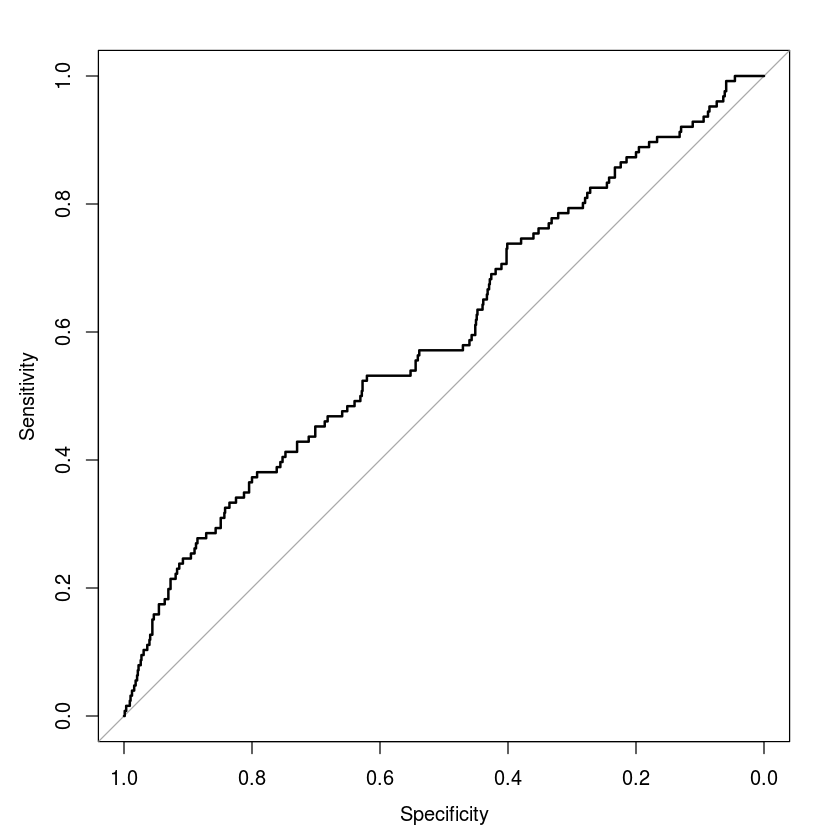

In [70]:
using(caret, pROC)

roc.logistic <- test.logistic  %$% roc(has.readmit.wi.90days, pred) 
roc.logistic 
roc.logistic %>% plot

Let's define a few helper functions to cleanly deal with the output.

In [82]:
YN <- . %>% 
        ifelse(., 'Yes', 'No') %>% 
        factor(levels=c('Yes', 'No'))

In [83]:
tidy.confusionMatrix <- function(x,...){
    names(x$overall) <- 
        c( "Accuracy"
         , "Kappa"
         , "Accuracy 95% CI lower"
         , "Accuracy 95% CI upper"
         , "No Information Rate"
         , "P-Value [Acc > NIR]"
         , "Mcnemar's Test P-Value"
         )
    bind_cols( as.data.frame(t(x$overall))
             , as.data.frame(t(x$byClass))
             )
}

In [98]:
model_metrics <- function(model, test, cutoff=NULL){
    probs <- predict(model, test, type='response')
    truth <- model.response(model.frame(model, data=data))
    if (is.null(cutoff))
        cutoff <- sort(unique(probs), decreasing=TRUE)
    
    
    map(cutoff, `<`, probs) %>%
    map(YN) %>%
    map(caret::confusionMatrix, reference=YN(truth), positive = 'Yes') %>%
    map_df(tidy) %>%
    cbind(cutoff = cutoff, .)
}

We will choose a cutoff that maximizes F1

In [113]:
mm <- model_metrics(readmission.logistic, test)
cut <- mm %>%
    filter(F1 == max(F1, na.rm=TRUE)) %$%
    cutoff
cut

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

[1] 0.1434365

In [114]:
filter(mm, cutoff %in% cut)

cutoff,Accuracy,Kappa,Accuracy 95% CI lower,Accuracy 95% CI upper,No Information Rate,P-Value [Acc > NIR],Mcnemar's Test P-Value,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
0.1434365,0.7465209,0.130106,0.7184459,0.773145,0.8747515,1,1.835276e-09,0.3730159,0.8,0.2107623,0.899106,0.2107623,0.3730159,0.269341,0.1252485,0.04671968,0.22167,0.5865079


A slightly more clean view.

In [115]:
test.logistic %>% 
    # confussionMatrix expects labels.
    mutate( true_class = YN(has.readmit.wi.90days)
          , pred_class = YN(pred > cut)
          ) %$%
    caret::confusionMatrix(pred_class, true_class)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes  47 176
       No   79 704
                                          
               Accuracy : 0.7465          
                 95% CI : (0.7184, 0.7731)
    No Information Rate : 0.8748          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1301          
 Mcnemar's Test P-Value : 1.835e-09       
                                          
            Sensitivity : 0.37302         
            Specificity : 0.80000         
         Pos Pred Value : 0.21076         
         Neg Pred Value : 0.89911         
             Prevalence : 0.12525         
         Detection Rate : 0.04672         
   Detection Prevalence : 0.22167         
      Balanced Accuracy : 0.58651         
                                          
       'Positive' Class : Yes             
                                          

OK so how did we do?  
**Discuss**

In [116]:















# nothing here

### Selecting variables
We might be able to improve estimates by selecting the variable that belong in the model. 

The `glmnet` package is used for fitting elastic net for glm models.

In [117]:
using(glmnet)
# define our model matrix
train.x <- model.matrix(readmission.logistic)
# define our model response
train.y <- model.response(model.frame(readmission.logistic))

# cross validate our 
readmit.glm.lasso.cv <- 
    cv.glmnet( x = train.x
             , y = train.y
             , family = "binomial"
             , nfolds = 10
             )

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-10



Now that we have crossvalidated elastic now let's investigate and choose the parameters.

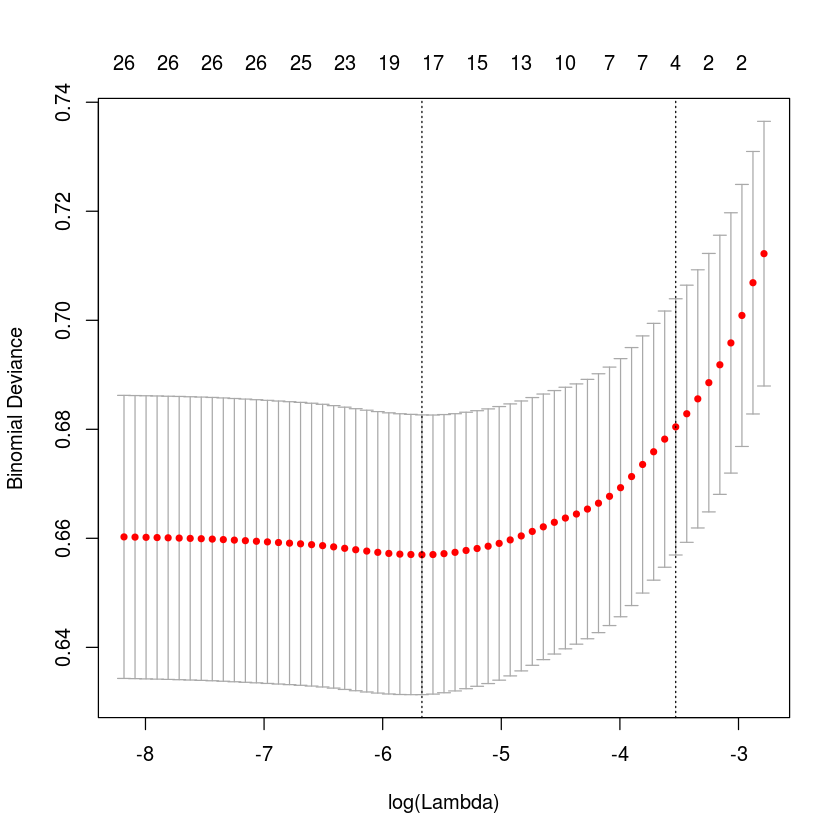

In [118]:
plot(readmit.glm.lasso.cv)

Shown is the cross validated error and the choise of lambda that minimizes that error.   Also shown is the choice of lambda within the one standard error, which often performs better than the minimin lambda.  But we have testing data as well.

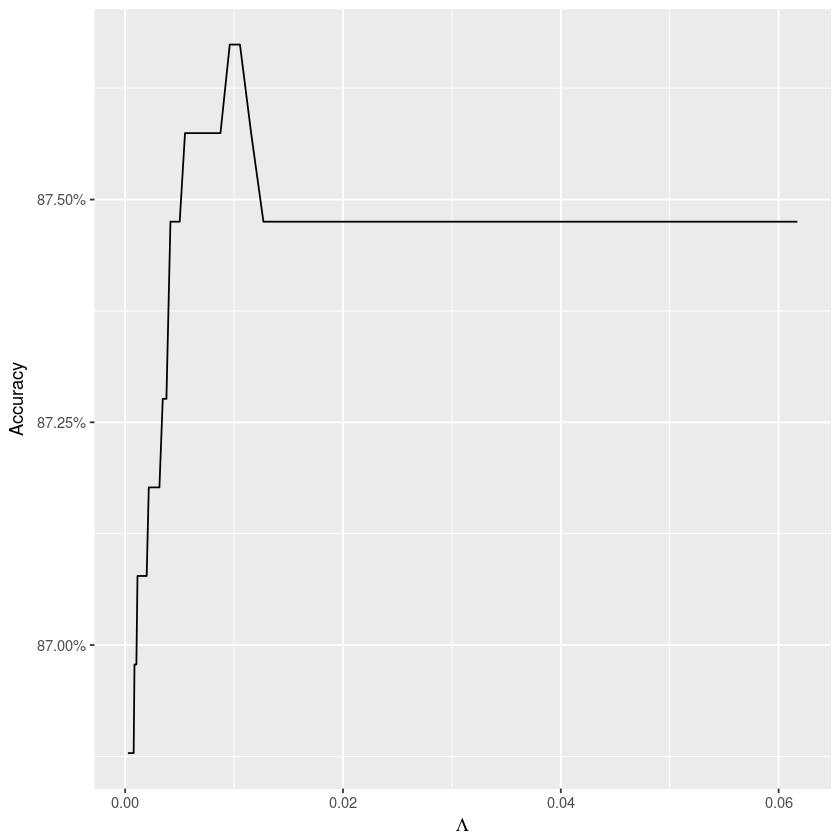

In [126]:
readmit.glm.lasso <- 
    glmnet( x = model.matrix(readmission.logistic)
          , y = model.response(model.frame(readmission.logistic))
          , family = "binomial"
          )

test.lasso.preds <- 
    predict( readmit.glm.lasso
           , newx =  model.matrix(formula(readmission.logistic), data =test)
           , type = 'response'
           )

Accuracy <- colSums((test.lasso.preds > 0.5) == (test$has.readmit.wi.90days)) / nrow(test)
qplot( x = readmit.glm.lasso$lambda
     , y = Accuracy
     , geom = "line"
     ) + 
    labs( x = expression(Lambda)
        , y = "Accuracy"
        ) + 
    scale_y_continuous(labels = scales::percent)


Call:
roc.default(response = test$has.readmit.wi.90days, predictor = test.lasso.preds[,     ix])

Data: test.lasso.preds[, ix] in 880 controls (test$has.readmit.wi.90days FALSE) < 126 cases (test$has.readmit.wi.90days TRUE).
Area under the curve: 0.6101

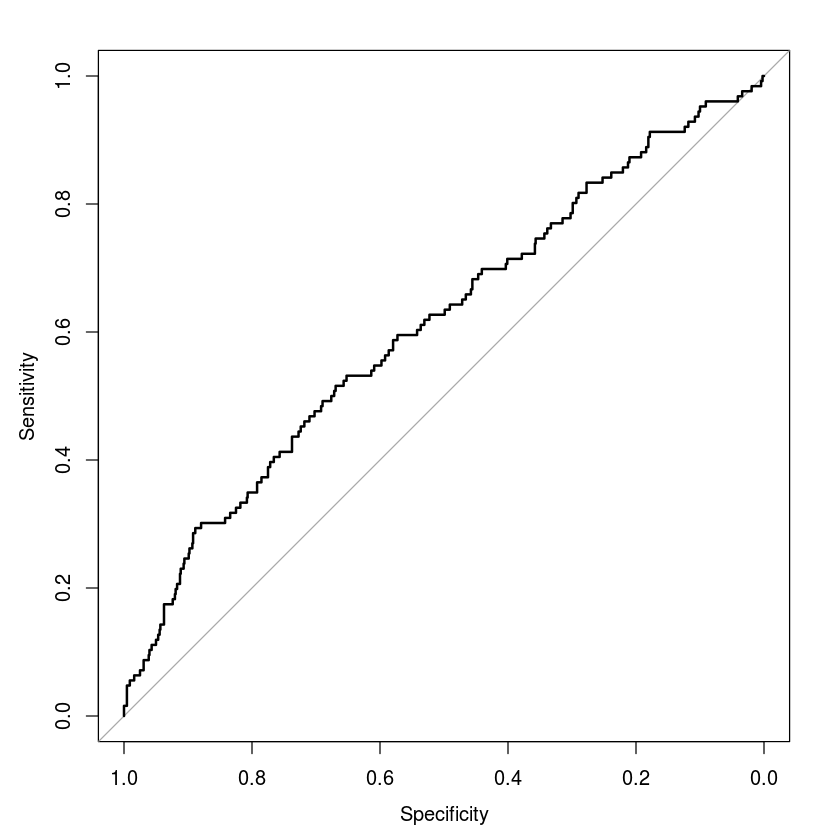

In [132]:
ix <- max(which(Accuracy == max(Accuracy)))

roc.lasso <- roc( test$has.readmit.wi.90days
                , test.lasso.preds[, ix]
                )

plot(roc.lasso)
roc.lasso


### Random Forest
 The random forest is an ensemble method, which we will talk about on day 4.  For now we treat it as a black box and see i fit can do any better.

The `randomForest` is an older package that requires data variable names to be valid R names.  It also will not perform automatic conversion of character to factor (categorical) variables so we must do that explicitly.  

In [134]:
clean_names <- function(data){
    names(data) <- make.names(names(data))
    data
}

In [135]:
library(randomForest)
readmision.forest <- 
    randomForest( data= train %>% 
                         select(-subject_id, -hadm_id) %>%
                         clean_names() %>% 
                         mutate( has.readmit.wi.90days = YN(has.readmit.wi.90days)
                               , sex = factor(sex)
                               )
                , has.readmit.wi.90days ~ .
                ) 

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [136]:
test.tbl <- test %>% clean_names %>% mutate(sex = factor(sex))

prob  = predict(readmision.forest, test.tbl, type='prob') %>% tbl_df
class = predict(readmision.forest, test.tbl, type='response')
test.rf <- test.tbl %>%
     bind_cols(prob, class=class)



Call:
roc.default(response = has.readmit.wi.90days, predictor = Yes)

Data: Yes in 880 controls (has.readmit.wi.90days FALSE) < 126 cases (has.readmit.wi.90days TRUE).
Area under the curve: 0.6452

0,5
0,8


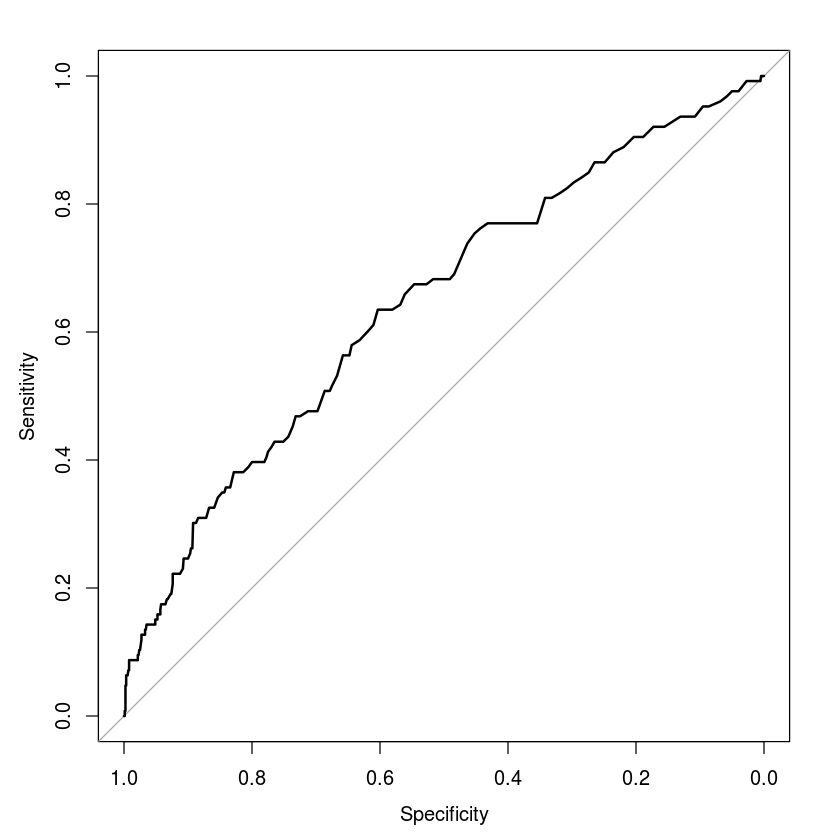

In [138]:
roc.rf <- test.rf %$% roc(has.readmit.wi.90days, `Yes`)
roc.rf
plot(roc.rf)
test.rf %$% confusionMatrix(class, has.readmit.wi.90days)

# Appendix - Investigations into the tables

### segmenting tables by purpose

In [ ]:

Names <- .%>% head(1) %>% collect %>% names

names.table <- lapply(mimic, Names) %>% lapply(tidy) %>% plyr::ldply(.) %>%
    rename('table'= '.id', 'var'='x') %>%
    mutate(has=TRUE) %>%
    spread(var, has, fill=FALSE)
names.table %>% filter(icustay_id, hadm_id)
count(icustay_detail)
glimpse(icustay_detail)


names.table %>% #filter(grepl('icu', table)) %>%
    filter(icustay_id) %>%
    select(table, ends_with("_id"))



In [ ]:
names(mimic) %>% sift("icu")
names(mimic) %>% sift("items")
names(mimic) %>% sift("duration")
names(mimic) %>% sift("events")

names(mimic) %>% sieve("icu") %>% sieve("items") %>% sieve('duration') %>% 
    sieve("events")


glimpse(chartevents)
count(d_chartitems)
glimpse(d_chartitems)
d_chartitems %>% collect %>% filter(grepl('height|weight', tolower(label)))

chart <- chartevents %>% left_join(d_chartitems) 

chart %>% 
     filter(label %in% c('Height Inches', 'Present Weight (kg)', 'Weight Kg'))

chartevents %>% anti_join(d_chartitems) %>% count 


count(chart)
count(chart, label)

In [ ]:
Names(microbiologyevents)


### ICU table

In [ ]:
source("../get_duplicated.R")
count(icustayevents)
glimpse(icustayevents)
admissions %>% anti_join(icustayevents) %>% count
glimpse(icustayevents)

In [ ]:
icustayevents %>%
    count(hadm_id) %>% ungroup %>%
    count(n)

### ICD-9

In [ ]:
glimpse(icd9)

In [ ]:
str(admit.data)

In [ ]:
save(admit.data, file = "admit.RData")